In [1]:
!pip install tensorflow==2.15 adapt scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikeras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.7 MB/s eta 0:00:00
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131790 sha256=5176d7c19da85e1010676e3852cb9503154b75c5136ad107db521ee3556ac7df
  Stored in directory: /root/.cache/pip/wheels/08/0d/83/cddcdf4c320d019e09107acf8d47ff9c7e01115ebad09567b4
Succe

In [2]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
  !pip install adapt
else:
  from umap import UMAP

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

Using Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.8 MB/s eta 0:00:00


In [3]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu121
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.73 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [4]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 545kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.91MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.02MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



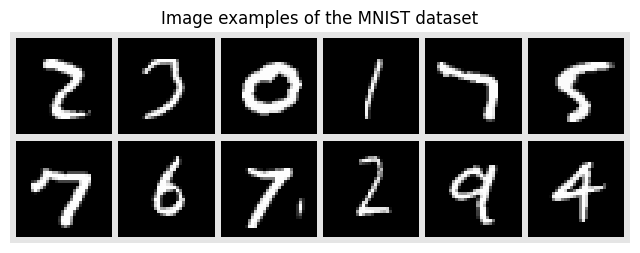

In [5]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating teh Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [6]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()


In [7]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [8]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()


In [9]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


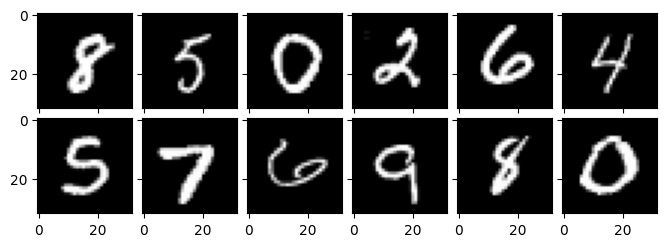

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 $x$ 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32$x$32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [11]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

100%|██████████| 182M/182M [00:06<00:00, 26.5MB/s]


100%|██████████| 64.3M/64.3M [00:05<00:00, 12.0MB/s]


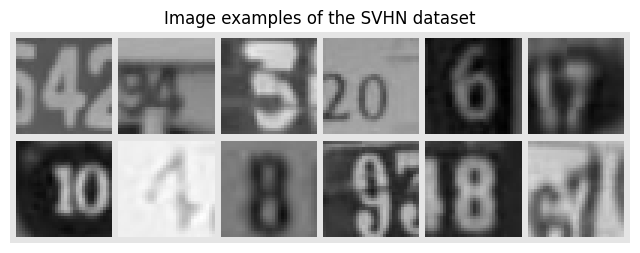

In [12]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [13]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [14]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 $x$ 32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16$x$16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 $x$ 32$ images.

In [15]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

100%|██████████| 6.58M/6.58M [00:01<00:00, 5.32MB/s]


100%|██████████| 1.83M/1.83M [00:00<00:00, 1.92MB/s]


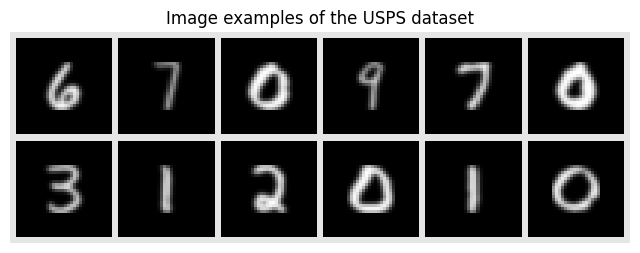

In [16]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [17]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [18]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 $x$ 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [19]:
print(MNIST_Xtrain_ima.shape)

(60000, 32, 32)


In [20]:
# MNIST
MNIST_Xtrain=MNIST_Xtrain_ima.reshape(MNIST_Xtrain_ima.shape[0],-1) # -1 or 1024
MNIST_Xtest=MNIST_Xtest_ima.reshape(MNIST_Xtest_ima.shape[0],-1)

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain=USPS_Xtrain_ima.reshape(USPS_Xtrain_ima.shape[0],-1)
USPS_Xtest=USPS_Xtest_ima.reshape(USPS_Xtest_ima.shape[0],-1)

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain=SVHN_Xtrain_ima.reshape(SVHN_Xtrain_ima.shape[0],-1)
SVHN_Xtest=SVHN_Xtest_ima.reshape(SVHN_Xtest_ima.shape[0],-1)

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [21]:
n_samples = 1000

# Reduced MNIST
indices_mnist = torch.randperm(MNIST_Xtrain.shape[0])[:n_samples]
MNIST_Xtrain_res = MNIST_Xtrain[indices_mnist,:]
MNIST_ytrain_res = MNIST_ytrain[indices_mnist]

# Reduced USPS
indices_usps = torch.randperm(USPS_Xtrain.shape[0])[:n_samples]
USPS_Xtrain_res = USPS_Xtrain[indices_usps,:]
USPS_ytrain_res = USPS_ytrain[indices_usps]

# Reduced SVHN
indices_svhn = torch.randperm(SVHN_Xtrain.shape[0])[:n_samples]
SVHN_Xtrain_res = SVHN_Xtrain[indices_svhn,:]
SVHN_ytrain_res = SVHN_ytrain[indices_svhn]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [22]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3000, 2)


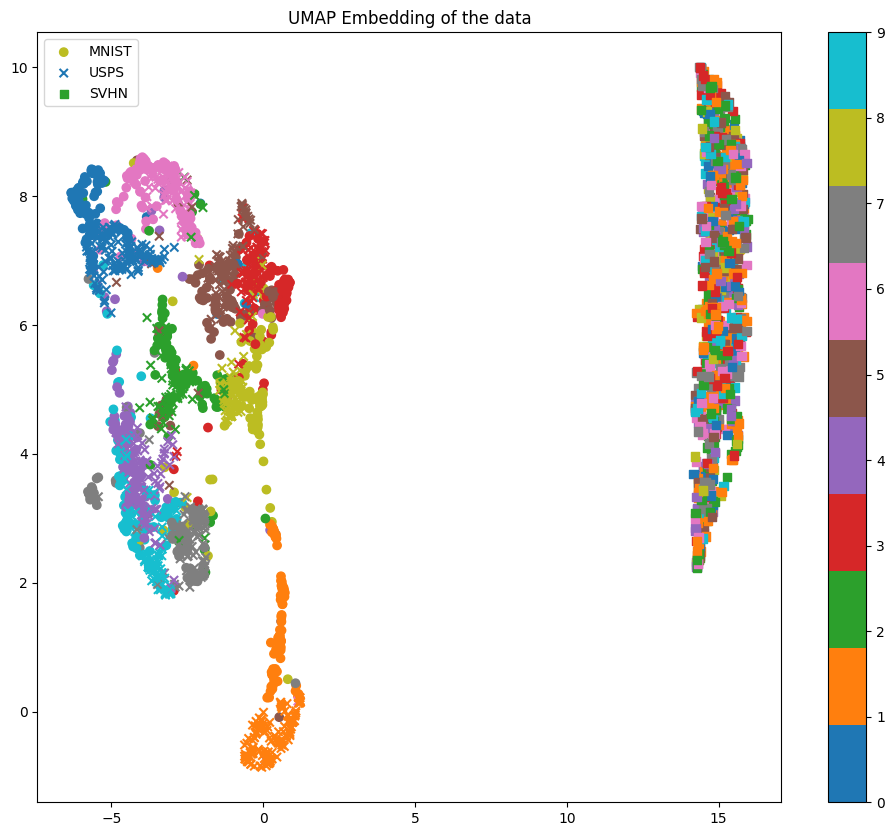

In [23]:

plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

According to the plot, the distribution of SVHN dataset is quite different to the other two datasets' distribution. In fact, one critical aspect that may be the cause to this is that the digits captured by MNIST and USPS datasets are hand-written where as those included in SVHN are not ( it seems more like printed since its for house numbering ).

We can conclude that our covariate shift assumption precisely the part that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal doesn't hold.

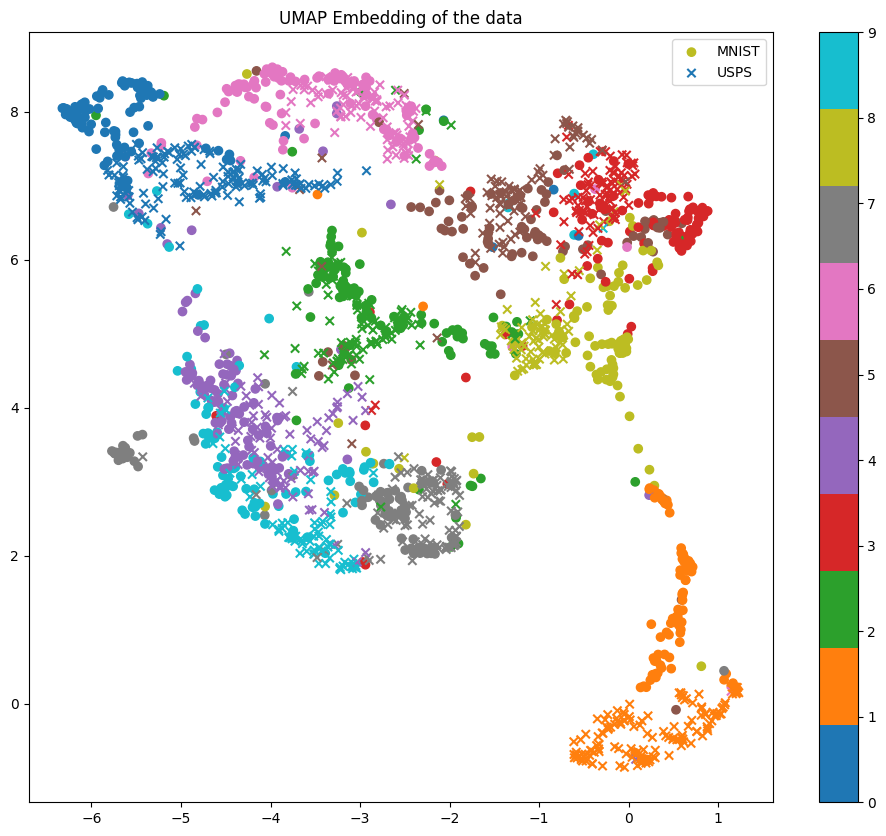

In [24]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Can you see a domain shift between the datasets ?

Yes, the hypothesis that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal holds perfectly, thus we can see a domain shift between these datasets.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [25]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 27.1 s, sys: 185 ms, total: 27.3 s
Wall time: 27.9 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


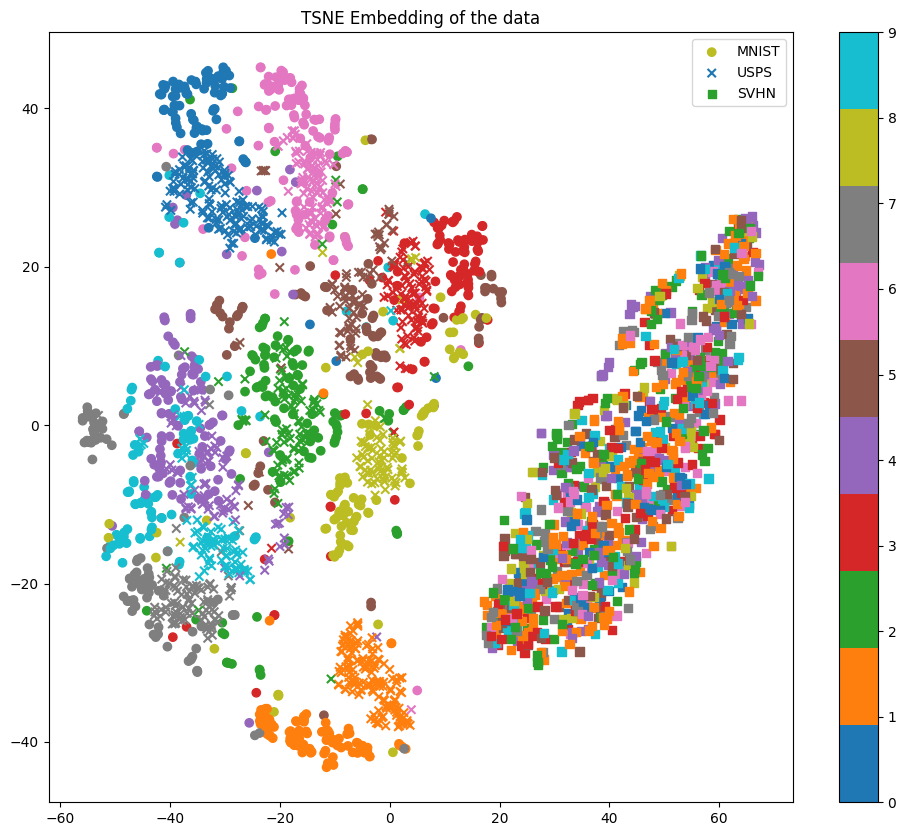

In [26]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

Yes, basically we can draw the same conclusions as previously, namely the SVHN dataset having a conditional ditribution quite different from that of the two remaining datasets.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

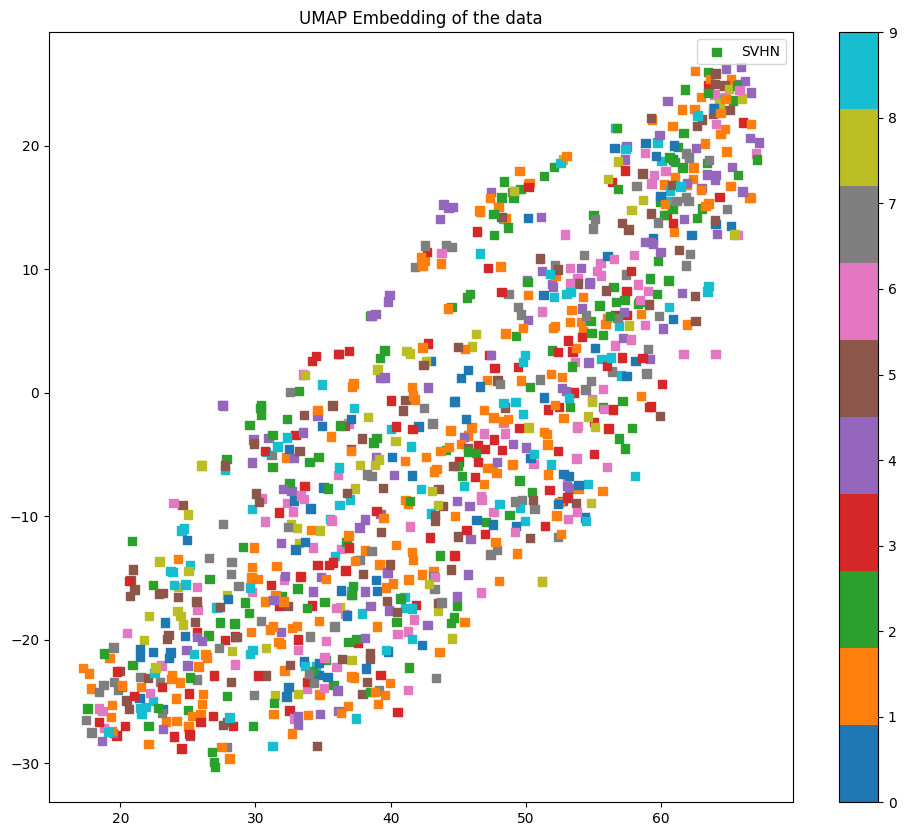

In [27]:
plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

No, the data can not be clustered neither well-separated compared to the other datasets. This is likely because the SVHN dataset (house numbers) includes many digit styles and different backround even among the same class which provides too complex features to be seperated into distinct clusters using UMAP.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 $x$ 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previousyly computed reduced datasets to speed up computations.

In [28]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [29]:
from sklearn.decomposition import PCA

def SA(XTrainS,XTestS,XTrainT,XTestT,d=10):
  """
  Subspace Alignment (SA)

  Input
  XTrainS : Input training source data [NTrS,D]
  XTestS : Input test source data [NTeS,D]
  XTrainT : Input training target data [NTrT,D]
  XTestT : Input test target data [NTeT,D]
  d : number of PCA components

  Output
  XTrainSp : projected and transformed source training data [NTrS,d]
  XTestSp : projected and transformed source test data [NTeS,d]
  XTrainTp : projected training target data [NTrT,d]
  XTestTp : projected test target data [NTeT,d]
  """

  U_S = PCA(n_components=d).fit(XTrainS).components_.T
  U_T = PCA(n_components=d).fit(XTrainT).components_.T
  #print(f"XTrainS: {XTrainS.shape}")
  #print(f"XTrainT: {XTrainT.shape}")
  #print(f"U_S shape: {U_S.shape}")
  #print(f"U_T shape: {U_T.shape}")
  M_star = np.dot(U_S.T,U_T)
  a=np.dot(XTrainS,U_S)
  XTrainSp = np.dot(a,M_star)
  XTestSp = np.dot(np.dot(XtestS,U_S),M_star)
  XTrainTp = np.dot(XtrainT,U_T)
  XTestTp = np.dot(XTestT,U_T)

  return XTrainSp,XTestSp,XTrainTp,XTestTp


We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [30]:
from sklearn.ensemble import RandomForestClassifier


rf_0 = RandomForestClassifier(n_estimators=100)
rf_0.fit(XtrainS, ytrainS)
print(rf_0.score(XtestS, MNIST_ytest))
print(rf_0.score(XtestT, USPS_ytest))

0.9068
0.5864474339810662


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

In [31]:
D = [10,50,75,100,500,1000]

for d in D:
  print(f"d=",d)
  pca = PCA(n_components=d)
  pca.fit(XtrainS)
  XtrainS_pca = pca.transform(XtrainS)
  XtestS_pca = pca.transform(XtestS)
  XtrainT_pca = pca.transform(XtrainT)
  XtestT_pca = pca.transform(XtestT)

  rf_1= RandomForestClassifier(n_estimators=100)
  rf_1.fit(XtrainS_pca, ytrainS)
  source_acc = rf_1.score(XtestS_pca, ytestS)
  target_acc = rf_1.score(XtestT_pca, ytestT)

  print(f"Source test accuracy: {source_acc}")
  print(f"Target test accuracy: {target_acc}")

d= 10
Source test accuracy: 0.8247
Target test accuracy: 0.4255107125062282
d= 50
Source test accuracy: 0.8777
Target test accuracy: 0.4569008470353762
d= 75
Source test accuracy: 0.8675
Target test accuracy: 0.45092177379172893
d= 100
Source test accuracy: 0.8575
Target test accuracy: 0.4439461883408072
d= 500
Source test accuracy: 0.7555
Target test accuracy: 0.35625311410064775
d= 1000
Source test accuracy: 0.6656
Target test accuracy: 0.3876432486297957


We see that when we technically use all of the components for high values of $d$, the performance deteriorates for both source and target accuracy... Even with the best performance which is obtained for $d=50$, it's considerably worse than the previous full-training data approach, this is especially for the target test accuracy : $45.69\% < 59.64\%$.

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

In [30]:
from sklearn.linear_model import LogisticRegression
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [31]:
class classifierNet(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(classifierNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    """
    Train the classifier model.

    Args:
        model: The PyTorch model to be trained.
        train_loader: DataLoader for the training dataset.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        num_epochs: Number of training epochs.

    Returns:
        model: Trained model.
    """
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            # Flatten the input
            inputs = inputs.view(inputs.size(0), -1)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
    return model


def evaluation_model(model, test_loader):
    """
    Evaluate the classifier model.

    Args:
        model: The PyTorch model to be evaluated.
        test_loader: DataLoader for the test dataset.

    Returns:
        accuracy: Accuracy of the model on the test dataset.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Flatten the input
            inputs = inputs.view(inputs.size(0), -1)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # Update metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


d=10
Logistic Regression:
Source test accuracy: 0.7913
Target test accuracy: 0.4469357249626308
Random Forest:
Source test accuracy: 0.8048
Target test accuracy: 0.5386148480318884
Neural Network:
Source test accuracy: 0.3884
Target test accuracy: 0.34778276033881417
d=50
Logistic Regression:
Source test accuracy: 0.8673
Target test accuracy: 0.6093672147483806
Random Forest:
Source test accuracy: 0.8624
Target test accuracy: 0.5724962630792227
Neural Network:
Source test accuracy: 0.87
Target test accuracy: 0.6417538614848032
d=75
Logistic Regression:
Source test accuracy: 0.8574
Target test accuracy: 0.6203288490284006
Random Forest:
Source test accuracy: 0.8521
Target test accuracy: 0.49725959142999504
Neural Network:
Source test accuracy: 0.8729
Target test accuracy: 0.6023916292974589
d=100
Logistic Regression:
Source test accuracy: 0.8554
Target test accuracy: 0.6108619830592925
Random Forest:
Source test accuracy: 0.8445
Target test accuracy: 0.4718485301444943
Neural Network:
S

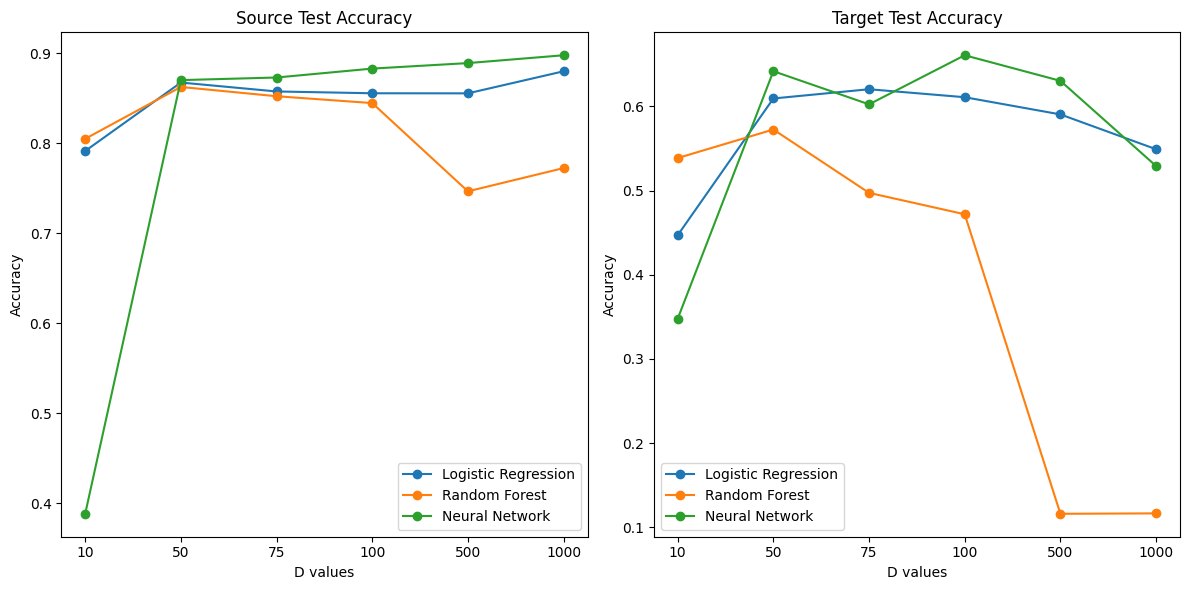

In [35]:
import matplotlib.pyplot as plt

# Initialize lists to store results for plotting
source_accuracies = {'Logistic Regression': [], 'Random Forest': [], 'Neural Network': []}
target_accuracies = {'Logistic Regression': [], 'Random Forest': [], 'Neural Network': []}

for d in D:
    print(f"d={d}")
    XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

    # Logistic Regression
    lr_2 = LogisticRegression(max_iter=1000)
    lr_2.fit(XTrainSp, ytrainS)
    source_acc_lr = lr_2.score(XTestSp, ytestS)
    target_acc_lr = lr_2.score(XTestTp, ytestT)
    print("Logistic Regression:")
    print(f"Source test accuracy: {source_acc_lr}")
    print(f"Target test accuracy: {target_acc_lr}")
    source_accuracies['Logistic Regression'].append(source_acc_lr)
    target_accuracies['Logistic Regression'].append(target_acc_lr)

    # Random Forest
    rf_2 = RandomForestClassifier(n_estimators=100)
    rf_2.fit(XTrainSp, ytrainS)
    source_acc_rf = rf_2.score(XTestSp, ytestS)
    target_acc_rf = rf_2.score(XTestTp, ytestT)
    print("Random Forest:")
    print(f"Source test accuracy: {source_acc_rf}")
    print(f"Target test accuracy: {target_acc_rf}")
    source_accuracies['Random Forest'].append(source_acc_rf)
    target_accuracies['Random Forest'].append(target_acc_rf)

    # Neural Network
    a = XTrainSp.reshape(XTrainSp.shape[0], -1)
    input_size = a.shape[1]
    model = classifierNet(input_size, 2 * input_size, input_size // 2, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(TensorDataset(torch.from_numpy(XTrainSp).float(), torch.from_numpy(ytrainS).long()), batch_size=32, shuffle=True)
    test_loaderS = DataLoader(TensorDataset(torch.from_numpy(XTestSp).float(), torch.from_numpy(ytestS).long()), batch_size=32, shuffle=False)
    test_loaderT = DataLoader(TensorDataset(torch.from_numpy(XTestTp).float(), torch.from_numpy(ytestT).long()), batch_size=32, shuffle=False)
    model = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
    source_acc_nn = evaluation_model(model, test_loaderS)
    target_acc_nn = evaluation_model(model, test_loaderT)
    print("Neural Network:")
    print(f"Source test accuracy: {source_acc_nn}")
    print(f"Target test accuracy: {target_acc_nn}")
    source_accuracies['Neural Network'].append(source_acc_nn)
    target_accuracies['Neural Network'].append(target_acc_nn)

# Plot the results
methods = list(source_accuracies.keys())
x = range(len(D))  # Assuming D is iterable and of fixed length

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Source accuracy plot
for method in methods:
    ax[0].plot(x, source_accuracies[method], marker='o', label=method)
ax[0].set_title("Source Test Accuracy")
ax[0].set_xlabel("D values")
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(x)
ax[0].set_xticklabels([str(d) for d in D])
ax[0].legend()

# Target accuracy plot
for method in methods:
    ax[1].plot(x, target_accuracies[method], marker='o', label=method)
ax[1].set_title("Target Test Accuracy")
ax[1].set_xlabel("D values")
ax[1].set_ylabel("Accuracy")
ax[1].set_xticks(x)
ax[1].set_xticklabels([str(d) for d in D])
ax[1].legend()

plt.tight_layout()
plt.show()

It looks like the RandomForest is over all decreasing to the point it gets really too low for high d values and even at its best performance it didn't outperform the target test accuracy before SA ( we get roughly 59% again ).

For the logisitic regression, it increases rather as d increases and outperforms a little bit the 59% and achieved almost 62%.

For the simple fully connected neural network, even though it starts with the lowest accuracy for d=10, it achieves the best overall accuracy namely for d=100 with an accuracy of 66% with a gain of about 7% which is not negligeable at all. We shoudl pinpoint as well, that the training accuracy is still at 88% which suggests we can achieve better results if we train for more epochs eventually.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

In [36]:
XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d=10)

xtotp=np.concatenate((XTrainSp,XTrainTp),axis=0) # MNIST & USPS data after SA
nSp=XTrainSp.shape[0]
nTp=XTrainTp.shape[0]

xpp = UMAP().fit_transform(xtotp) # this should take ~50sec

print(xpp.shape)

# separate again but now in 2D
xpS=xpp[:nSp,:]
xpT=xpp[nSp:nSp+nTp,:]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(2000, 2)


In [37]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3000, 2)


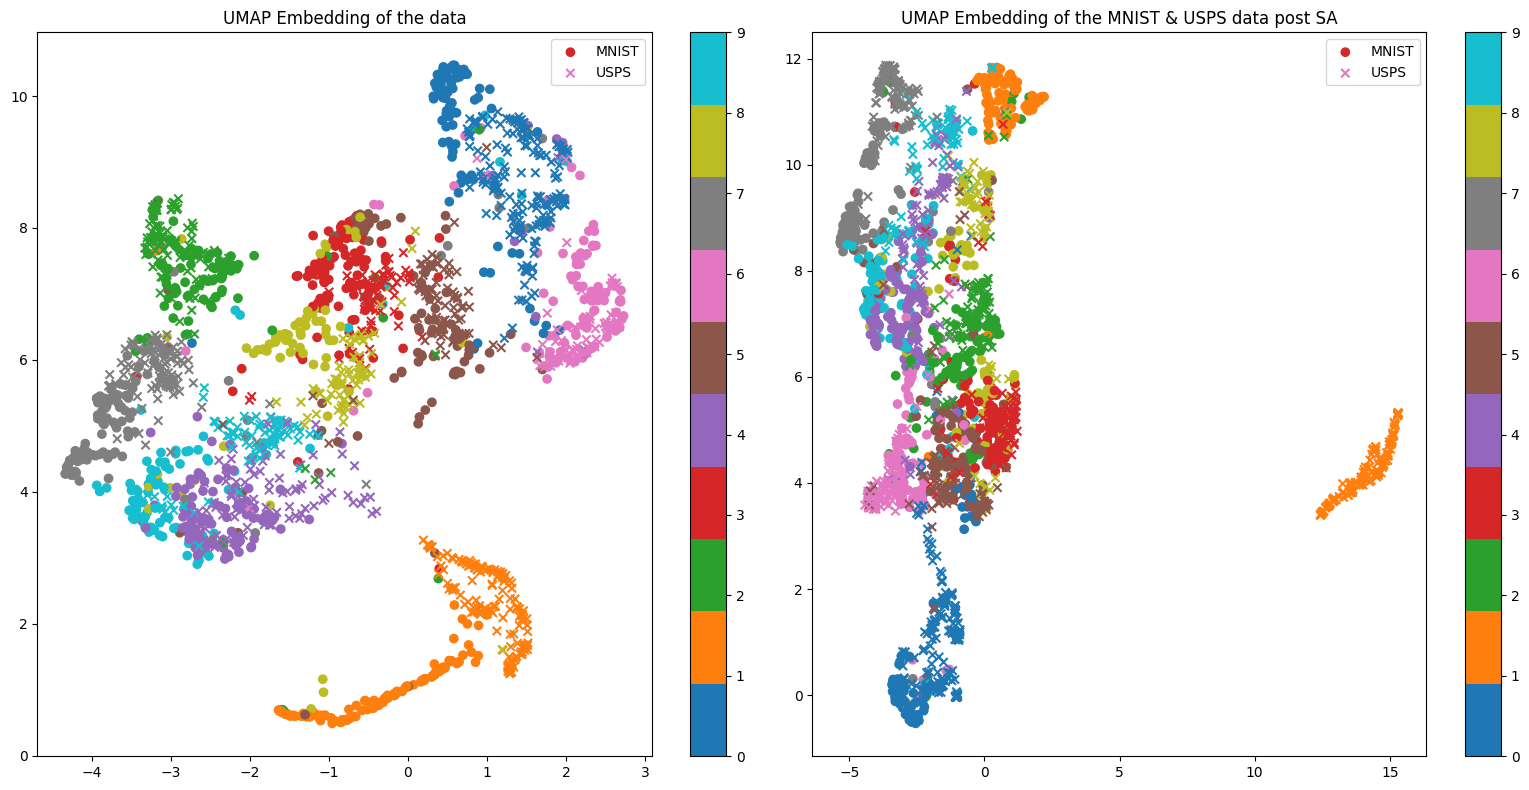

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First plot: UMAP Embedding of the data
axes[0].scatter(xpMNIST[:, 0], xpMNIST[:, 1], c=MNIST_ytrain_res, marker='o', cmap='tab10', label='MNIST')
axes[0].scatter(xpUSPS[:, 0], xpUSPS[:, 1], c=USPS_ytrain_res, marker='x', cmap='tab10', label='USPS')
axes[0].legend()
axes[0].set_title('UMAP Embedding of the data')
axes[0].colorbar = fig.colorbar(axes[0].collections[-1], ax=axes[0])

# Second plot : UMAP Embedding of the MNIST & USPS data post SA
axes[1].scatter(xpS[:, 0], xpS[:, 1], c=MNIST_ytrain_res, marker='o', cmap='tab10', label='MNIST')
axes[1].scatter(xpT[:, 0], xpT[:, 1], c=USPS_ytrain_res, marker='x', cmap='tab10', label='USPS')
axes[1].legend()
axes[1].set_title('UMAP Embedding of the MNIST & USPS data post SA')
axes[1].colorbar = fig.colorbar(axes[1].collections[-1], ax=axes[1])

plt.tight_layout()
plt.show()

We used UMAP for visualization. In fact, it appears like we have clearer clusters and the MNIST and USPS classes are closer for the classes 4, 5 and 7. Nevertheless, it turns out to be bad for the class 1, in fact, the two classes where already far from each other ( they are next to each other, but we can distinguish clearly two clusters), and now they are even farther!

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

Source: USPS, Target: SVHN
d=10
Logistic Regression | Source Acc: 0.7050323866467364, Target Acc: 0.1470881991395206
Random Forest | Source Acc: 0.6731439960139511, Target Acc: 0.0956899200983405
Neural Network | Source Acc: 0.37070254110612855, Target Acc: 0.13744622003687768
d=50
Logistic Regression | Source Acc: 0.8849028400597907, Target Acc: 0.0912338660110633
Random Forest | Source Acc: 0.8849028400597907, Target Acc: 0.14397664413030117
Neural Network | Source Acc: 0.8609865470852018, Target Acc: 0.11332206515058389
d=75
Logistic Regression | Source Acc: 0.8913801694070752, Target Acc: 0.10659956976029503
Random Forest | Source Acc: 0.8973592426507224, Target Acc: 0.13794560540872772
Neural Network | Source Acc: 0.8704534130543099, Target Acc: 0.11170866625691457
d=100
Logistic Regression | Source Acc: 0.8923766816143498, Target Acc: 0.11773970497848801
Random Forest | Source Acc: 0.9013452914798207, Target Acc: 0.126459741856177
Neural Network | Source Acc: 0.8963627304434479, 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


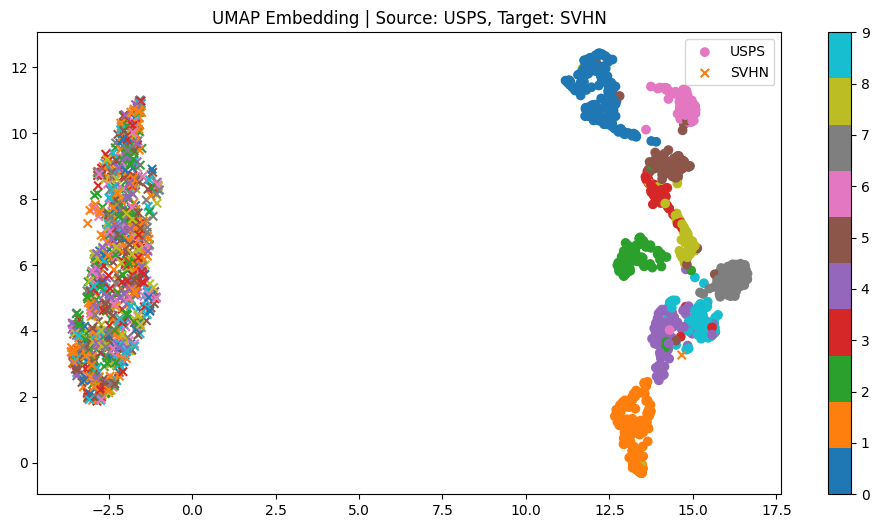

Source: MNIST, Target: SVHN
d=10
Logistic Regression | Source Acc: 0.6659, Target Acc: 0.1589582052858021
Random Forest | Source Acc: 0.6219, Target Acc: 0.1164720344191764
Neural Network | Source Acc: 0.2672, Target Acc: 0.07790411800860479
d=50
Logistic Regression | Source Acc: 0.8676, Target Acc: 0.15630762138905963
Random Forest | Source Acc: 0.8804, Target Acc: 0.14420712968653965
Neural Network | Source Acc: 0.8591, Target Acc: 0.1070221266133989
d=75
Logistic Regression | Source Acc: 0.8773, Target Acc: 0.14017363245236633
Random Forest | Source Acc: 0.8886, Target Acc: 0.1377919483712354
Neural Network | Source Acc: 0.8945, Target Acc: 0.16168561770129072
d=100
Logistic Regression | Source Acc: 0.8793, Target Acc: 0.10437154271665643
Random Forest | Source Acc: 0.8937, Target Acc: 0.1452443146896128
Neural Network | Source Acc: 0.9073, Target Acc: 0.11597264904732636
d=500
Logistic Regression | Source Acc: 0.8798, Target Acc: 0.10321911493546404
Random Forest | Source Acc: 0.87

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


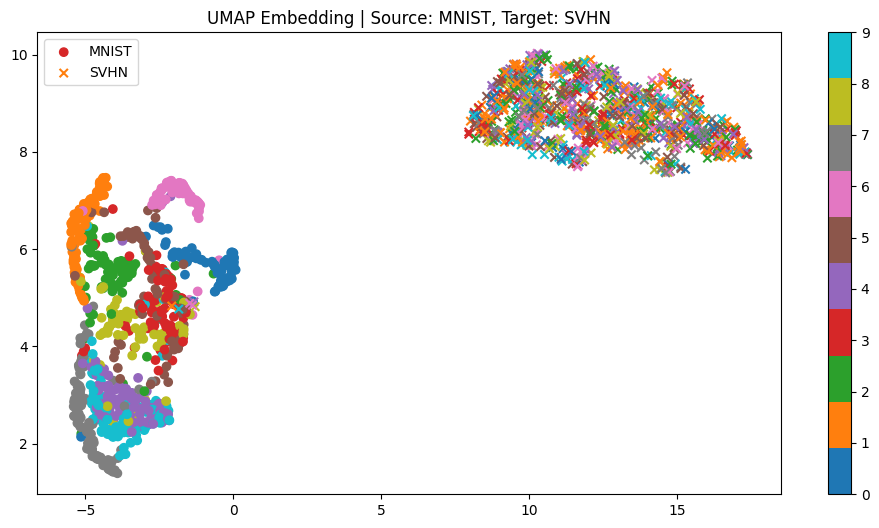

Source: USPS, Target: MNIST
d=10
Logistic Regression | Source Acc: 0.8380667663178873, Target Acc: 0.4431
Random Forest | Source Acc: 0.8295964125560538, Target Acc: 0.442
Neural Network | Source Acc: 0.5181863477827603, Target Acc: 0.3325
d=50
Logistic Regression | Source Acc: 0.8943697060288989, Target Acc: 0.5538
Random Forest | Source Acc: 0.8888888888888888, Target Acc: 0.4294
Neural Network | Source Acc: 0.8759342301943199, Target Acc: 0.485
d=75
Logistic Regression | Source Acc: 0.8938714499252616, Target Acc: 0.5423
Random Forest | Source Acc: 0.8824115595416044, Target Acc: 0.3707
Neural Network | Source Acc: 0.8849028400597907, Target Acc: 0.5018
d=100
Logistic Regression | Source Acc: 0.8958644743398106, Target Acc: 0.5384
Random Forest | Source Acc: 0.877927254608869, Target Acc: 0.3617
Neural Network | Source Acc: 0.8878923766816144, Target Acc: 0.5115
d=500
Logistic Regression | Source Acc: 0.9003487792725461, Target Acc: 0.5381
Random Forest | Source Acc: 0.8644743398106

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


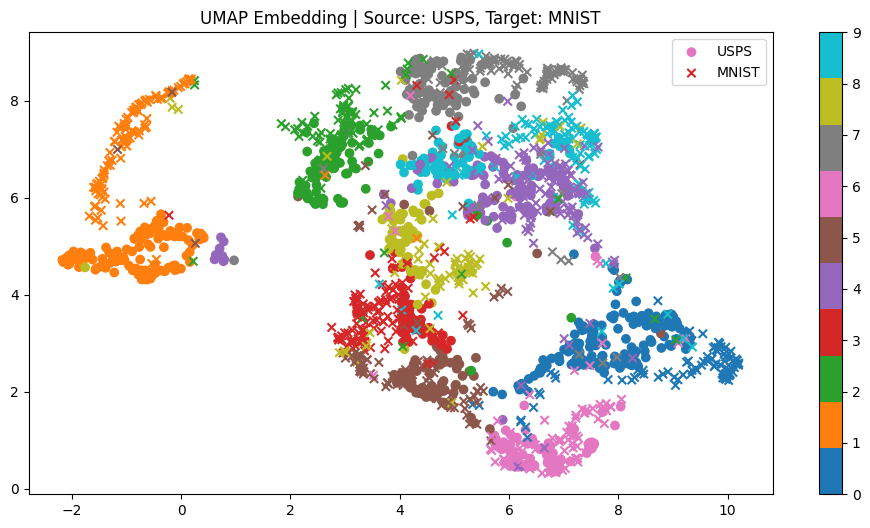

In [39]:
# Adjust domain configurations
domain_configurations = [
    {"source": "USPS", "target": "SVHN"},
    {"source": "MNIST", "target": "SVHN"},
    {"source": "USPS", "target": "MNIST"}  # New configuration
]

for config in domain_configurations:
    print(f"Source: {config['source']}, Target: {config['target']}")

    # Set source and target domains
    if config["source"] == "USPS":
        XtrainS, XtestS, ytrainS, ytestS = USPS_Xtrain_res, USPS_Xtest, USPS_ytrain_res, USPS_ytest
    elif config["source"] == "MNIST":
        XtrainS, XtestS, ytrainS, ytestS = MNIST_Xtrain_res, MNIST_Xtest, MNIST_ytrain_res, MNIST_ytest

    if config["target"] == "SVHN":
        XtrainT, XtestT, ytrainT, ytestT = SVHN_Xtrain_res, SVHN_Xtest, SVHN_ytrain_res, SVHN_ytest
    elif config["target"] == "MNIST":
        XtrainT, XtestT, ytrainT, ytestT = MNIST_Xtrain_res, MNIST_Xtest, MNIST_ytrain_res, MNIST_ytest

    # Repeat experiments for different d values
    for d in D:
        print(f"d={d}")
        XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

        # Logistic Regression
        lr = LogisticRegression(max_iter=1000)
        lr.fit(XTrainSp, ytrainS)
        source_acc_lr = lr.score(XTestSp, ytestS)
        target_acc_lr = lr.score(XTestTp, ytestT)

        print(f"Logistic Regression | Source Acc: {source_acc_lr}, Target Acc: {target_acc_lr}")

        # Random Forest
        rf = RandomForestClassifier(n_estimators=100)
        rf.fit(XTrainSp, ytrainS)
        source_acc_rf = rf.score(XTestSp, ytestS)
        target_acc_rf = rf.score(XTestTp, ytestT)

        print(f"Random Forest | Source Acc: {source_acc_rf}, Target Acc: {target_acc_rf}")

        # Neural Network
        model = classifierNet(XTrainSp.shape[1], 2 * d, d // 2, 10)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loader = DataLoader(
            TensorDataset(torch.from_numpy(XTrainSp).float(), torch.from_numpy(ytrainS).long()), batch_size=32, shuffle=True
        )
        test_loaderS = DataLoader(
            TensorDataset(torch.from_numpy(XTestSp).float(), torch.from_numpy(ytestS).long()), batch_size=32, shuffle=False
        )
        test_loaderT = DataLoader(
            TensorDataset(torch.from_numpy(XTestTp).float(), torch.from_numpy(ytestT).long()), batch_size=32, shuffle=False
        )

        model = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
        source_acc_nn = evaluation_model(model, test_loaderS)
        target_acc_nn = evaluation_model(model, test_loaderT)

        print(f"Neural Network | Source Acc: {source_acc_nn}, Target Acc: {target_acc_nn}")

    # Visualize UMAP embeddings for source and target domains
    xtotp = np.concatenate((XTrainSp, XTrainTp), axis=0)
    xpp = UMAP().fit_transform(xtotp)

    # Separate UMAP embeddings
    xpS, xpT = xpp[:XTrainSp.shape[0], :], xpp[XTrainSp.shape[0]:, :]

    plt.figure(figsize=(12, 6))
    plt.scatter(xpS[:, 0], xpS[:, 1], c=ytrainS, marker="o", cmap="tab10", label=config["source"])
    plt.scatter(xpT[:, 0], xpT[:, 1], c=ytrainT, marker="x", cmap="tab10", label=config["target"])
    plt.legend()
    plt.colorbar()
    plt.title(f"UMAP Embedding | Source: {config['source']}, Target: {config['target']}")
    plt.show()


Source : USPS ----> Target : SVHN
The best performance is achieved with the neural network, with an accuracy of 15% which is too low ( close to a random classifier that achieves 10%
For the UMAP plot, as expected, we don't see any major changes, the two data don't overlap at all basically.

Source : MNIST ----> Target : SVHN
Technically we can say the same conclusions as previously, with just a slight difference of the best performance with always the neural net at 16%.

Source : USPS ----> Target : MNIST
The best performance goes to the logistic regression with an accuracy of 54% which is good although worst then the reverse configuration where the MNIST data set is rather the source.
For the UMAP plot, we can draw the same conclusions, it's better for almost all the classes, better in the sense that we have better overlapping, but we have always the issue with the digit 1 class even though it didn't become farther like in the situation Source: MNIST and Target:USPS.

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

Running experiment with 500 samples
Running experiment with 250 samples
Running experiment with 100 samples


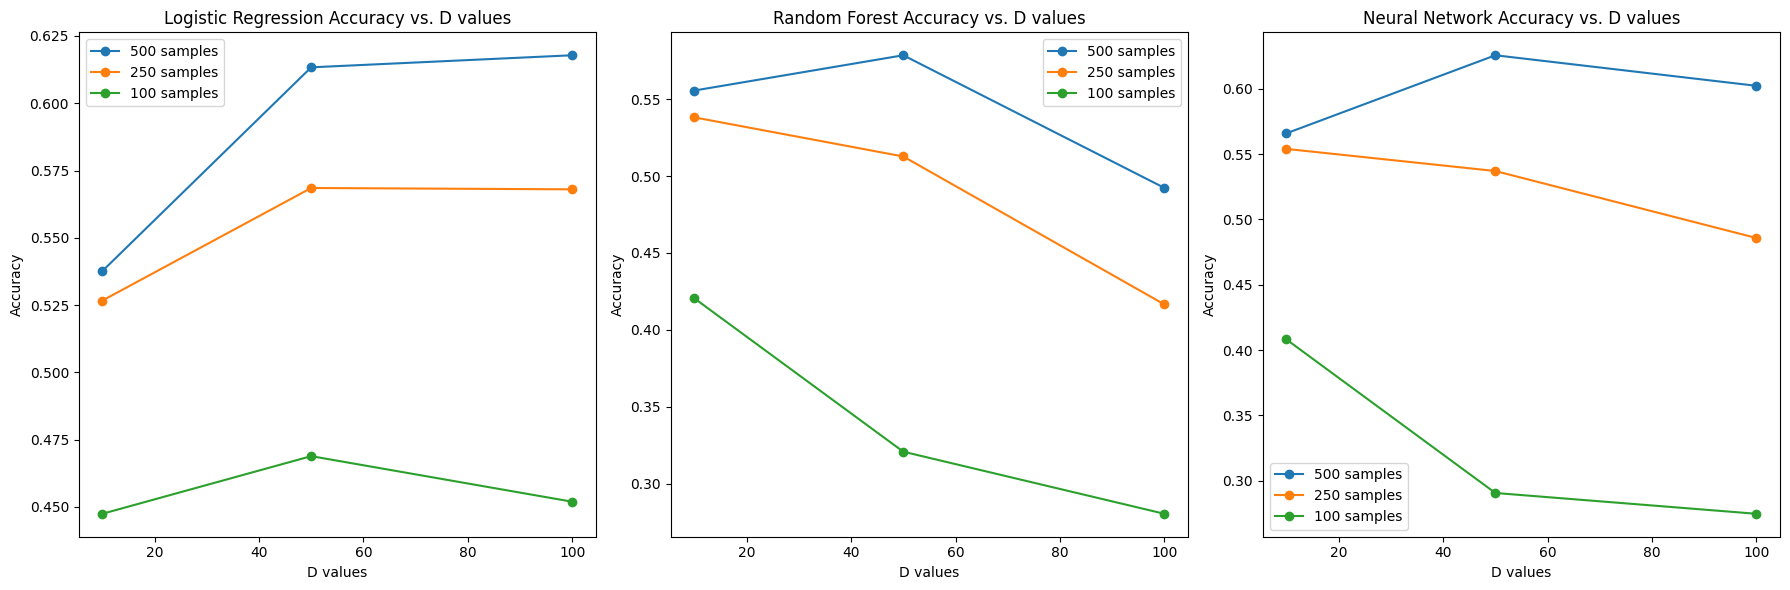

In [42]:
def run_experiment(sample_sizes, D_values):
    results = {size: {'Logistic Regression': [], 'Random Forest': [], 'Neural Network': []} for size in sample_sizes}

    for n_samples in sample_sizes:
        print(f"Running experiment with {n_samples} samples")

        indices_mnist = torch.randperm(MNIST_Xtrain.shape[0])[:n_samples]
        indices_usps = torch.randperm(USPS_Xtrain.shape[0])[:n_samples]

        XtrainS, ytrainS = MNIST_Xtrain[indices_mnist, :], MNIST_ytrain[indices_mnist]
        XtrainT, ytrainT = USPS_Xtrain[indices_usps, :], USPS_ytrain[indices_usps]

        for d in D_values:
            XTrainSp, XTestSp, XTrainTp, XTestTp = SA(XtrainS, XtestS, XtrainT, XtestT, d)

            # Logistic Regression
            lr = LogisticRegression(max_iter=1000)
            lr.fit(XTrainSp, ytrainS)
            results[n_samples]['Logistic Regression'].append(lr.score(XTestTp, ytestT))

            # Random Forest
            rf = RandomForestClassifier(n_estimators=100)
            rf.fit(XTrainSp, ytrainS)
            results[n_samples]['Random Forest'].append(rf.score(XTestTp, ytestT))

            # Neural Network
            model = classifierNet(XTrainSp.shape[1], 128, 64, 10)
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            train_loader = DataLoader(TensorDataset(torch.from_numpy(XTrainSp).float(), torch.from_numpy(ytrainS).long()), batch_size=32, shuffle=True)
            test_loaderT = DataLoader(TensorDataset(torch.from_numpy(XTestTp).float(), torch.from_numpy(ytestT).long()), batch_size=32, shuffle=False)
            model = train_model(model, train_loader, criterion, optimizer, num_epochs=10)
            results[n_samples]['Neural Network'].append(evaluation_model(model, test_loaderT))

    return results

# some numbers below 1000
sample_sizes = [500, 250, 100]
D_values = [10,50,100]

# Run the experiment
results = run_experiment(sample_sizes, D_values)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
methods = ['Logistic Regression', 'Random Forest', 'Neural Network']

for i, method in enumerate(methods):
    for n_samples in sample_sizes:
        ax[i].plot(D_values, results[n_samples][method], marker='o', label=f'{n_samples} samples')
    ax[i].set_title(f"{method} Accuracy vs. D values")
    ax[i].set_xlabel("D values")
    ax[i].set_ylabel("Accuracy")
    ax[i].legend()

plt.tight_layout()
plt.show()


As the number of samples decreases, the performance drops slowly from 1000 to 500 to 250 samples and it drops dramatically for n=100. This is expected since we know the complexity of the model is a O($\sqrt{\frac{log(n)}{n}}$) and thus, if n decreases, the error is no longer controlled with a small bound and thus, the error can be bigger which is exactly the case here.

**Optional**: You can test other methods using the `adapt`library. See `https://adapt-python.github.io/adapt/`

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

In [40]:
from adapt.feature_based import MDD
from tensorflow import keras
import numpy as np

# Ensure input data is compatible
print(f"XtrainS shape: {XtrainS.shape}")
print(f"XtrainT shape: {XtrainT.shape}")

# Define the encoder
encoder = keras.Sequential([
    keras.layers.InputLayer(input_shape=(XtrainS.shape[1],)),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10)  # Encoded representation for MDD
])

# Define the task classifier
task = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10,)),  # Match encoder output
    keras.layers.Dense(1, activation="softmax")  # Classification output
])

# Discriminator
discriminator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10,)),  # Match encoder output
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(2, activation="softmax")  # Binary domain classification
])

# Debugging: Check encoder output
encoder_output_sample = encoder(XtrainS[:1])
print(f"Encoder output sample shape: {encoder_output_sample.shape}")

# Initialize and train MDD model
model = MDD(encoder=encoder, task=task, Xt=XtrainT, metrics=["accuracy"])

# Train the model
try:
    model.fit(XtrainS, ytrainS, epochs=100, verbose=1)  # Set verbose to get detailed logs
except Exception as e:
    print(f"Error during training: {e}")

# Score the model
try:
    score = model.score(XtrainS, ytrainS)
    print(f"Model score: {score}")
except Exception as e:
    print(f"Error during scoring: {e}")


XtrainS shape: (1000, 1024)
XtrainT shape: (1000, 1024)
Encoder output sample shape: (1, 10)
Epoch 1/100
32/32 [==============================] - 3s 6ms/step - loss: 17.0254 - accuracy: 0.1475 - disc_loss: 0.0000e+00
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 17.0215 - accuracy: 0.1494 - disc_loss: 0.0000e+00
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 16.9229 - accuracy: 0.1436 - disc_loss: 0.0000e+00
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 16.7559 - accuracy: 0.1475 - disc_loss: 0.0000e+00
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 17.1787 - accuracy: 0.1436 - disc_loss: 0.0000e+00
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 16.8320 - accuracy: 0.1465 - disc_loss: 0.0000e+00
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 16.7441 - accuracy: 0.1504 - disc_loss: 0.0000e+00
Epoch 8/100
32/32 [====================

In [35]:
from adapt.feature_based import DANN
from tensorflow import keras
import tensorflow as tf

# Step 1: Define the encoder network
encoder = keras.Sequential([
    keras.layers.InputLayer(input_shape=(XtrainS.shape[1],)),  # Input size matches source domain
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(10)  # Encoded representation
])

# Step 2: Define the task classifier (Predicts digit class 0-9)
task = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10,)),  # Takes encoded features
    keras.layers.Dense(1, activation="softmax")
])

# Step 3: Define the discriminator (Predicts domain: Source vs Target)
discriminator = keras.Sequential([
    keras.layers.InputLayer(input_shape=(10,)),  # Takes encoded features
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(2, activation="softmax")  # Binary classification (Source=0, Target=1)
])

# Step 4: Initialize DANN model
model = DANN(
    encoder=encoder,
    task=task,
    discriminator=discriminator,  # Include discriminator
    Xt=XtrainT,  # Target domain data
    lambda_=1.0,  # Trade-off parameter
    metrics=["accuracy"],  # Track accuracy
    copy=False  # Prevent unnecessary copying
)

# Step 5: Train the model
model.fit(
    XtrainS, ytrainS,  # Source domain data
    Xt=XtrainT,  # Target domain data
    epochs=10,  # Use 10 epochs for testing
    batch_size=32,
    verbose=1
)

# Step 6: Evaluate performance on target domain
score = model.score(XtrainT, ytrainT)
print("DANN Model Score:", score)


Epoch 1/10
32/32 [==============================] - 2s 8ms/step - loss: 20.2061 - accuracy: 0.1006 - disc_loss: 2.1026 - disc_acc: 0.9920
Epoch 2/10
32/32 [==============================] - 0s 8ms/step - loss: 19.9824 - accuracy: 0.1045 - disc_loss: 2.4459 - disc_acc: 1.0000
Epoch 3/10
32/32 [==============================] - 0s 9ms/step - loss: 19.9844 - accuracy: 0.1025 - disc_loss: 1.6078 - disc_acc: 0.5436
Epoch 4/10
32/32 [==============================] - 0s 9ms/step - loss: 19.9102 - accuracy: 0.1045 - disc_loss: 8.0365 - disc_acc: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 0s 8ms/step - loss: 19.9980 - accuracy: 0.1006 - disc_loss: 10.6878 - disc_acc: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 0s 9ms/step - loss: 20.0586 - accuracy: 0.1025 - disc_loss: 9.4708 - disc_acc: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 0s 9ms/step - loss: 20.1211 - accuracy: 0.1025 - disc_loss: 3.0461 - disc_acc: 0.1979
Epoch 8/10
32/32 [===


**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...